### Helpers

In [1]:
# %load_ext autoreload
# %autoreload 2

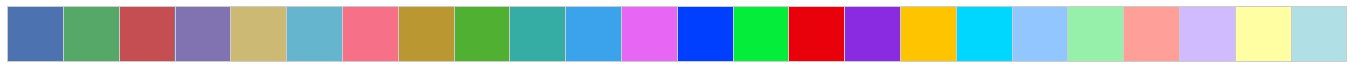

In [16]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.stats as sts
import seaborn as sns
from IPython.display import display
from common import *
from io_tools import (
    read_train, read_pub_test, read_pvt_test,
    convert_train, convert_pub_test, convert_pvt_test,
)
from pipeline import (
    split_classes, count_classes, sample,
    cross_validate, fit_predict_save, fit_save_model
)
from transformers.pca import pca_fit, pca_transform

sns.set()
sns.set_style("whitegrid")

color_palette = sns.color_palette('deep') + sns.color_palette('husl', 6) + sns.color_palette('bright') + sns.color_palette('pastel')

%matplotlib inline
sns.palplot(color_palette)

def ndprint(a, precision=3):
    with np.printoptions(precision=precision, suppress=True):
        print(a)

### Reading

In [17]:
# derivative cols

nerr_x_cols = ['NErr_X[%i]' % i for i in range(N_STATIONS)]
nerr_y_cols = ['NErr_Y[%i]' % i for i in range(N_STATIONS)]
nerr_xy_cols = nerr_x_cols + nerr_y_cols

da_cols = ['DAngle[%d]' % i for i in range(1, 4)]
is_muon_cols = ['IsMuonTight']
prob_hit_detector_cols = ['ProbHit[%i]' % i for i in range(N_STATIONS)]
err_cols = ['ErrMSE', 'Chi2Quantile']

In [19]:
%%time
used_cols = xyz_cols + mom_cols + hit_type_cols + dxyz_cols + exy_cols + edxy_cols
train = read_train(used_cols, 200000)
display(train.shape, count_classes(train))

(200000, 48)

(100000, 100000)

Wall time: 460 ms


### Data transformer

Это по сути основная часть. Класс, который отбирает нужные столбцы, возможно что-то модифицирует или добавляет. На выходе - входные данные для модели.

##### PCA

##### Cosine dist

In [27]:
def add_coses(data, features):
    def get_layer_coords(data, i):
        return data[[x_cols[i], y_cols[i], z_cols[i]]].values

    def dot(x, y):
        return np.sum(x * y, axis=1, dtype=np.float32)
    
    def norm(x):
        return np.sqrt(dot(x, x))

    def get_cosine_dist(L1, L2, L1_norm, L2_norm):
        return dot(L1, L2) / L1_norm / L2_norm
    
    def get_angle(cosines):
        return np.arccos(cosines) / np.pi * 180.
    
    layers = np.array([get_layer_coords(data, i) for i in range(4)])
    layers[1:] -= layers[:3]
    norms = list(map(norm, layers))
    
    for i in range(3):
        cosines = get_cosine_dist(layers[i], layers[i+1], norms[i], norms[i+1])
        angles = get_angle(cosines)
        data[da_cols[i]] = angles
        
    features += da_cols        
    return data

##### IsMuon && IsMuonTight

In [21]:
def add_is_muon_tight(data, features):
    return add_is_muon(data, features, threshold=2)
    
def add_is_muon(data, features, threshold=1):
    def lt(p):
        return data.P < p
    def gt(p):
        return data.P >= p
    def M(i):
        return data[hit_type_cols[i]] >= threshold
    
    lt_6k_mask = lt(6000.) & M(0) & M(1)
    lt_10k_gt_6k_mask = gt(6000.) & lt(10000.) & M(0) & M(1) & (M(2) | M(3))
    gt_10k_mask = gt(10000.) & M(0) & M(1) & M(2) & M(3)
    
    data.loc[:, is_muon_cols[0]] = 1 * (lt_6k_mask | lt_10k_gt_6k_mask | gt_10k_mask)
    features += is_muon_cols        
    return data

##### Probability hit detector

In [22]:
def add_probability_hit_detector(data, features):
    p = data[mom_cols[0]].values
    
    def prob(i):
        alpha = (0.0260, 0.0021, 0.0015, 0.0008)
        beta = (2040., 2387., 3320., 3903.)
        t = (alpha[i] * (p - beta[i]))**(i+1)
        return t / (1 + t)
        
    for i in range(4):
        data.loc[:, prob_hit_detector_cols[i]] = prob(i)
        
    features += prob_hit_detector_cols
    return data

##### MSE

In [23]:
def add_mse(data, features):
    dxy = (data.loc[:, xy_cols].values - data.loc[:, exy_cols].values) / data.loc[:, dx_cols + dy_cols].values / 2.
    D = np.mean(dxy**2, axis=1)
    
    data.loc[:, err_cols[0]] = D
    features += [err_cols[0]]
    return data

In [24]:
def add_normed_err(data, features):
    dxy = data.loc[:, xy_cols].values - data.loc[:, exy_cols].values
    normed_errors = dxy / np.sqrt(data.loc[:, edxy_cols].values)
    
    for i in range(4):
        data.loc[:, nerr_x_cols[i]] = normed_errors[:, i]
        data.loc[:, nerr_y_cols[i]] = normed_errors[:, i + 4]
    
    features += nerr_xy_cols
    return data

In [28]:
%%time
from sklearn.base import TransformerMixin

class DataTransformer(TransformerMixin):
    def __init__(self, *featurizers):
        self.featurizers = featurizers
    
    def fit(self, data, y=None):
#         self.pca_model = pca_fit(data)
        return self

    def transform(self, data):
        data = data.copy()
        self.origin_features = [] + xyz_cols + mom_cols + hit_type_cols + exy_cols + edxy_cols + dxyz_cols
        features = self.origin_features.copy()

#         pca_transform(self.pca_model, data, features)
#         add_is_muon(data, features)
#         add_is_muon_tight(data, features)
#         add_probability_hit_detector(data, features)
        add_coses(data, features)
#         add_mse(data, features)
#         add_normed_err(data, features)
        
        self.features = features[len(self.origin_features):]
        return data[features].values

df_scores = cross_validate(train, n_estimators=60, n_splits=3, n_rows=4000, transformer_cls=DataTransformer)
display(df_scores.describe())

C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in arccos
  from ipykernel import kernelapp as app
C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':
C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in arccos
  from ipykernel import kernelapp as app
C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in arccos
  from ipykernel import kernelapp as app
C:\Anaconda3\envs\tf\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.0
mean,0.703250,0.652841,0.878472,0.749000,0.738638,0.505776,0.057768,0.0
std,0.003823,0.005323,0.007636,0.001212,0.013533,0.079137,0.005132,0.0
min,0.699925,0.647826,0.872024,0.747937,0.723304,0.432229,0.051907,0.0
25%,0.701162,0.650048,0.874256,0.748340,0.733500,0.463907,0.055926,0.0
50%,0.702399,0.652270,0.876488,0.748744,0.743695,0.495585,0.059944,0.0
75%,0.704913,0.655349,0.881696,0.749532,0.746304,0.542550,0.060699,0.0
max,0.707427,0.658427,0.886905,0.750320,0.748913,0.589515,0.061454,0.0


Wall time: 1.07 s


### Test theory

In [38]:
%%time
df_scores = cross_validate(train, n_estimators=120, n_splits=5, n_rows=100000, transformer_cls=DataTransformer)
display(df_scores.describe())

,acc,prec,rec,f1,roc_auc,scr,th,dTh
count,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.0
mean,0.695390,0.642672,0.883168,0.743959,0.727846,0.487659,0.052278,0.0
std,0.004964,0.004582,0.002148,0.003206,0.005140,0.026030,0.001084,0.0
min,0.690035,0.637166,0.879952,0.740262,0.721171,0.465830,0.050475,0.0
25%,0.690600,0.638847,0.882646,0.741202,0.725374,0.476795,0.052330,0.0
50%,0.696350,0.643647,0.883445,0.744435,0.726857,0.479790,0.052463,0.0
75%,0.698600,0.645592,0.883955,0.746018,0.731761,0.483129,0.052758,0.0
max,0.701365,0.648109,0.885840,0.747879,0.734067,0.532750,0.053367,0.0


Wall time: 46.6 s


### Get result

In [ ]:
convert_train

In [14]:
test = read_pub_test(used_cols)

In [15]:
%%time
fit_predict_save(sample(train, 10000), test, "out/03_baseline_head_100.csv", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 6.54 s


In [6]:
%%time
fit_save_model(sample(train, 100000), "models/07_dumb_cols.xgb", n_estimators=120, transformer_cls=DataTransformer)

Wall time: 11.5 s


In [7]:
sl = train.iloc[:5]

In [12]:
sl.head(1)

,MatchedHit_X[0],MatchedHit_X[1],MatchedHit_X[2],MatchedHit_X[3],MatchedHit_Y[0],MatchedHit_Y[1],MatchedHit_Y[2],MatchedHit_Y[3],MatchedHit_Z[0],MatchedHit_Z[1],...,Mextra_DX2[0],Mextra_DX2[1],Mextra_DX2[2],Mextra_DX2[3],Mextra_DY2[0],Mextra_DY2[1],Mextra_DY2[2],Mextra_DY2[3],label,weight
0,-953.080017,-1028.400024,-1072.170044,-1145.569946,2164.736572,2332.150391,2500.885254,2671.054932,15410.896484,16615.699219,...,110.538933,321.090912,712.326355,1362.196167,111.90007,325.044678,721.097534,1378.969482,0,1.745141


In [21]:
sl.values[:, :12][0]

array([ -953.08001709, -1028.40002441, -1072.17004395, -1145.56994629,
        2164.73657227,  2332.15039062,  2500.88525391,  2671.05493164,
       15410.89648438, 16615.69921875, 17809.10742188, 19017.8203125 ])

In [16]:
sl.loc[:, xyz_cols].values[0]

array([ -953.08  , -1028.4   , -1072.17  , -1145.57  ,  2164.7366,
        2332.1504,  2500.8853,  2671.055 , 15410.896 , 16615.7   ,
       17809.107 , 19017.82  ], dtype=float32)

In [17]:
sl[xyz_cols].values[0]

array([ -953.08  , -1028.4   , -1072.17  , -1145.57  ,  2164.7366,
        2332.1504,  2500.8853,  2671.055 , 15410.896 , 16615.7   ,
       17809.107 , 19017.82  ], dtype=float32)

In [19]:
sl.iloc[:, :12].values[0]

array([ -953.08  , -1028.4   , -1072.17  , -1145.57  ,  2164.7366,
        2332.1504,  2500.8853,  2671.055 , 15410.896 , 16615.7   ,
       17809.107 , 19017.82  ], dtype=float32)

### Scratches

In [410]:
a = pd.DataFrame([[1.0, np.NaN], [np.NaN, np.NaN], [2.0, 3.1]], columns=['a', 'b'])

In [95]:
train_backup = train

In [55]:
%%time
train = pd.read_csv('data/train_part_1_v2.csv.gz', na_values=['-9999.0', '255'], index_col=utils.ID_COLUMN)
# train = pd.read_csv('data/train_part_2_v2.csv.gz', nrows=10000, na_values=['-9999.0', '255'])
# train = pd.concat([train_0, train_1], axis=0, ignore_index=True)

label0 = train.loc[train.label==0, :]
label0.to_csv('data/train_pub_L0_p1.csv.gz', compression='gzip')

label1 = train.loc[train.label==1, :]
label1.to_csv('data/train_pub_L1_p1.csv.gz', compression='gzip')

C:\Anaconda3\envs\tf\lib\site-packages\numpy\lib\arraysetops.py:522: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


Wall time: 14min 16s


In [59]:
%%time
label0.to_pickle('data/train_pub_L0_p1.pkl')

Wall time: 2.53 s


In [61]:
%%time
label1.to_pickle('data/train_pub_L1_p1.pkl')

Wall time: 48.3 s


In [70]:
label0.shape, label1.shape

((210403, 79), (2512449, 79))

#### Reading

In [ ]:
%%time
train = pd.read_csv('data/train_part_2_v2.csv.gz', na_values=['-9999.0', '255'], index_col=utils.ID_COLUMN)
# train = pd.read_csv('data/train_part_2_v2.csv.gz', nrows=10000, na_values=['-9999.0', '255'])
# train = pd.concat([train_0, train_1], axis=0, ignore_index=True)

label0 = train.loc[train.label==0, :]
label0.to_csv('data/train_pub_L0_p2.csv.gz', compression='gzip')

label1 = train.loc[train.label==1, :]
label1.to_csv('data/train_pub_L1_p2.csv.gz', compression='gzip')

In [52]:
# label0_ = pd.read_csv('data/train_pub_L0_p1.csv', nrows=10000, na_values=['-9999.0', '255'], index_col=utils.ID_COLUMN)

# print(label0.shape, label0_.shape)

# for c in label0.columns:
#     lc0 = label0.loc[:, c]
#     if not np.issubdtype(lc0.dtype, np.number):
#         continue
#     lc0_ = label0_.loc[:, c]
#     mask = (lc0 - lc0_).abs() > 1e-10
#     if mask.sum() > 0 :
#         display(lc0[mask] - lc0_[mask])
        

# for c in label0.columns:
#     lc0 = label0.loc[:, c]
#     if np.issubdtype(lc0.dtype, np.number):
#         continue
#     lc0_ = label0_.loc[:, c]
#     mask = (lc0 != lc0_) & (lc0 == lc0) & (lc0_ == lc0_)
#     for i in range(mask.sum()):
#         s0 = ''.join(lc0.iloc[mask].iloc[i].split())
#         s1 = ''.join(lc0_.iloc[mask].iloc[i].split())
#         if s0 == s1:
#             continue
        
#         print(lc0.iloc[0])
#         print(lc0_.iloc[0])
#         for i,s in enumerate(difflib.ndiff(lc0.iloc[0], lc0_.iloc[0])):
#             if s[0]==' ': continue
#             elif s[0]=='-':
#                 print(u'Delete "{}" `{}` from position {}'.format(s[-1], ord(s[-1]),i))
#             elif s[0]=='+':
#                 print(u'Add "{}" `{}` to position {}'.format(s[-1],ord(s[-1]),i))    
#         print()  

# display(label0[mask].head(10))
# display(label0_[mask].head(10))

(736, 79) (736, 79)
Wall time: 702 ms
